In [1]:
import torch
import typing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import sqrt, atan, pi, degrees

# Part 1: Limits of the Perceptron

## Constructing Datasets

In [130]:
def make_dataset(set: list[float], rule: str) -> tuple[torch.tensor, torch.tensor]:
    # Get the length of the set
    N = len(set)

    # Build an NxN tensor of 1x2 tensors
    x = torch.ones(N, N, 1,2, dtype=float)

    # Use NxN tensor indices to assign values to 1x2 tensors
    for i in range(N):
        for j in range(N):
            x[i,j] = torch.tensor([set[i], set[j]])

    # Reshape to (N^2)x2 tensor
    x = x.reshape(N**2, 2)

    # Build an (N^2)x1 tensor for the labels
    y = torch.ones(N**2,1, dtype=float)

    # Assign labels according to rule
    for i in range(N**2):
        if rule == "linear":
            # Sign function: label(x1,x2) = 1 (x2 > x1) else 0
            if x[i,1] <= x[i,0]:
                y[i] = 0
        elif rule == "xor":
            # XOR function: label(x1, x2) = x1 ^ x2
            if (x[i,0] == 1 and x[i,1] == 1) or (x[i,0] == -1 and x[i,1] == -1):
                y[i] = 0
        else:
            raise ValueError("Unexpected value for 'rule': must be one of 'linear', 'xor'")
        
    return x, y

def plot_dataset(x1, x2, y, title, labels={'red': "y=0", 'blue': "y=1"}, marker_size=1):
    colors = ['red' if y_val == 0 else 'blue' for y_val in y]
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=labels['red'],
            markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='o', color='w', label=labels['blue'],
            markerfacecolor='blue', markersize=8),
    ]
    fig, ax = plt.subplots()
    ax.scatter(x1, x2, c=colors, s=marker_size)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.title(title)
    
    return fig,ax

### Dataset 1: Linear Boundary

Text(0.5, 1.0, 'Dataset 1: Linear Boundary')

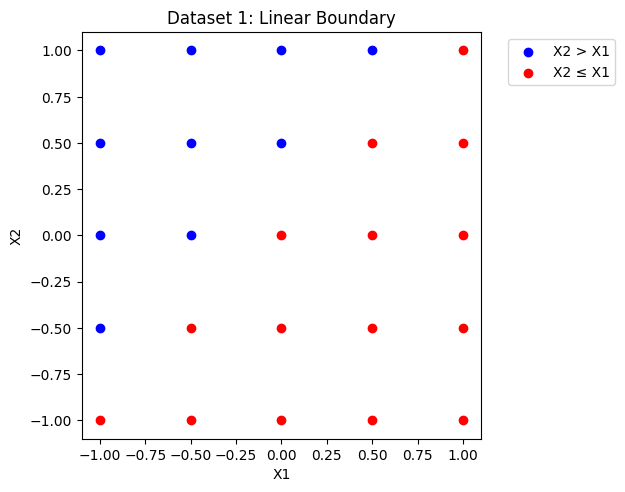

In [3]:
# Define the set
S = [-1, -0.5, 0, 0.5, 1]
x_linear, y_linear = make_dataset(set=S, rule='linear')

# View sample space]
fig, ax = plt.subplots()
ax.scatter(x_linear[(y_linear == 1)[:,0],0], x_linear[(y_linear == 1)[:,0],1], c='b', label='X2 > X1')
ax.scatter(x_linear[(y_linear == 0)[:,0],0], x_linear[(y_linear == 0)[:,0],1], c='r', label='X2 ≤ X1')
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.title("Dataset 1: Linear Boundary")


### Dataset 2: XOR Problem

Text(0.5, 1.0, 'Dataset 2: XOR Problem')

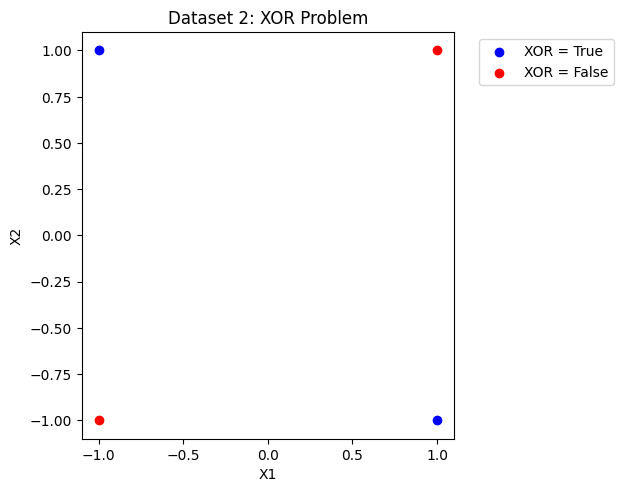

In [96]:
# Define the set
S = [-1, 1]
x_xor, y_xor = make_dataset(set=S, rule='xor')

# View sample space
fig, ax = plt.subplots()
ax.scatter(x_xor[(y_xor == 1)[:,0],0], x_xor[(y_xor == 1)[:,0],1], c='b', label='XOR = True')
ax.scatter(x_xor[(y_xor == 0)[:,0],0], x_xor[(y_xor == 0)[:,0],1], c='r', label='XOR = False')
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.title("Dataset 2: XOR Problem")

## Training Perceptron

In [70]:
class Perceptron():
    def __init__(self, input_size):
        sigma = 1 / sqrt(input_size)
        self.biases = torch.tensor([0], dtype=float, requires_grad=False)
        self.weights = torch.randn(input_size, dtype=float, requires_grad=False) * sigma

    def forward(self, x: torch.tensor) -> torch.tensor:
        z = torch.dot(self.weights, x) + self.biases
        y_hat = sign(z)
        return y_hat
    
    def backward(self, x: torch.tensor, y: torch.tensor, y_hat: torch.tensor, 
        lr: float = 0.001) -> tuple[torch.tensor, torch.tensor]:
        # Calculate the error in the output layer
        delta_y = y_hat - y

        # Calculate the new weights
        w = self.weights - lr * delta_y * x

        # Calculate the new biases
        b = self.biases - lr * delta_y

        # Return the new parameters
        return w, b

    def train(self, x_train: torch.tensor, y_train: torch.tensor, epochs: int = 100, lr: float = 0.001):
        # Evaluation metrics
        training_accuracies = []
        decision_boundary_angles = []
        print(f'{"Epoch":<10} \t {"Training Accuracy":^25} \t {"Decision Boundary Angle":>10}')
        print("-" * 100)

        # Train for the number of epochs
        for epoch in range(epochs):
            # In each epoch, iterate over the entire dataset one example at a time (i.e., no mini-batching)
            for i, x in enumerate(x_train):
                # Get the label by index
                y = y_train[i]

                # Get predictions with a forward pass
                y_hat = self.forward(x)

                # Get new parameters with a backward pass
                w, b = self.backward(x, y, y_hat, lr)

                # Update parameters
                self.weights = w
                self.biases = b
            
            # Save evaluation metrics for the epoch
            accuracy = self.evaluate(x_eval=x_train, y_eval=y_train)
            boundary_angle = degrees(atan((self.weights[1]/self.weights[0])) + pi/2)
            training_accuracies.append(accuracy)
            decision_boundary_angles.append(boundary_angle)
        
            if epoch % 10 == 9:
                print(f"{(epoch + 1):<10} \t {accuracy:^25.5f} \t {boundary_angle:>10.2f}")

        return training_accuracies, decision_boundary_angles
    
    def evaluate(self, x_eval: torch.tensor, y_eval: torch.tensor):
        # Variable to store accuracy
        N_correct = 0

        # In each epoch, iterate over the entire dataset one example at a time (i.e., no mini-batching)
        for i, x in enumerate(x_eval):
            # Get the label by index
            y = y_eval[i]

            # Get predictions with a forward pass
            y_hat = self.forward(x)
            if (y_hat - y) == 0:
                N_correct += 1
        
        accuracy = N_correct / len(x_eval)
        
        return accuracy


def sign(z):
    if z > 0:
        return 1
    else:
        return 0

def plot_model_accuracy(accuracies: list, angles: typing.Optional[list] = None, title: str = ""):
    if angles is None:
        fig, ax1 = plt.subplots()
        ax_to_label = ax1
        ax2 = None
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
        ax_to_label = ax2
    
    ax1.plot(range(len(accuracies)), accuracies)
    ax1.set_ylabel("Model Accuracy")
    ax1.grid()
    if ax2:
        ax2.plot(range(len(angles)), angles)
        ax2.set_ylabel("Decision Boundary Angle")
        ax2.grid()
    ax_to_label.set_xlabel("Epoch")

    plt.suptitle(title)

    

Epoch      	     Training Accuracy     	 Decision Boundary Angle
----------------------------------------------------------------------------------------------------
10         	          0.20000          	      11.44
20         	          0.28000          	       3.97
30         	          0.32000          	     165.89
40         	          0.64000          	     116.66
50         	          0.92000          	      55.25
60         	          1.00000          	      51.31
70         	          1.00000          	      51.31
80         	          1.00000          	      51.31
90         	          1.00000          	      51.31
100        	          1.00000          	      51.31
Epoch      	     Training Accuracy     	 Decision Boundary Angle
----------------------------------------------------------------------------------------------------
10         	          0.50000          	     136.44
20         	          0.50000          	     136.44
30         	          0.50000          	    

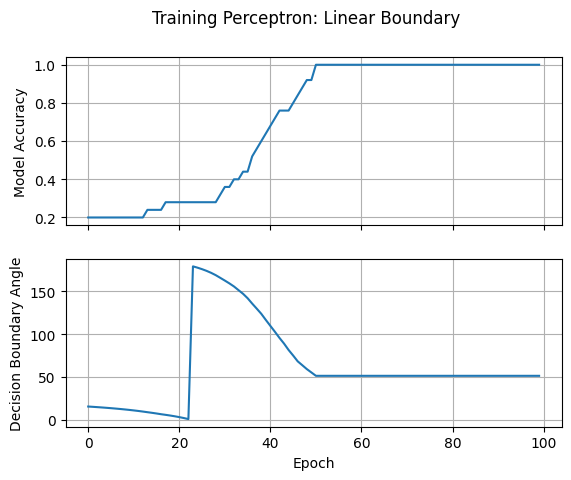

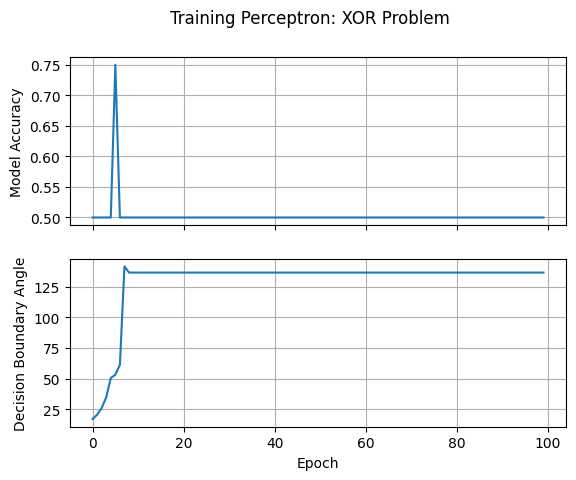

In [84]:
N_epochs = 100

linear_perceptron = Perceptron(input_size=x_linear.shape[1])
xor_perceptron = Perceptron(input_size=x_xor.shape[1])

accuracies, angles = linear_perceptron.train(x_train=x_linear, y_train=y_linear, epochs = N_epochs)
plot_model_accuracy(accuracies, angles, title='Training Perceptron: Linear Boundary')

accuracies, angles = xor_perceptron.train(x_train=x_xor, y_train=y_xor, epochs = N_epochs, lr=0.1)
plot_model_accuracy(accuracies, angles, title='Training Perceptron: XOR Problem')

/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_86164/2967177115.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ys = (-1/linear_perceptron.weights[1]) * (linear_perceptron.weights[0] * xs + linear_perceptron.biases)


Text(0.5, 1.0, 'Perceptron Performance: Linear Boundary')

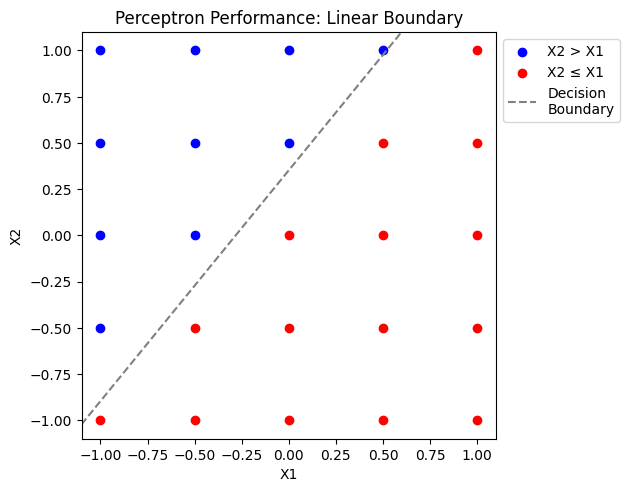

In [85]:
# Calculate decision barrier
# w1 * x1 + w2 * x2 + b = 0
# x2 = (-1/w2) * (w1 * x1 + b)
xs = np.linspace(-2, 2, 100)
ys = (-1/linear_perceptron.weights[1]) * (linear_perceptron.weights[0] * xs + linear_perceptron.biases)

# View sample space with model
fig, ax = plt.subplots()
ax.scatter(x_linear[(y_linear == 1)[:,0],0], x_linear[(y_linear == 1)[:,0],1], c='b', label='X2 > X1')
ax.scatter(x_linear[(y_linear == 0)[:,0],0], x_linear[(y_linear == 0)[:,0],1], c='r', label='X2 ≤ X1')
ax.plot(xs, ys, color='gray', linestyle='--', label='Decision\nBoundary')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.title("Perceptron Performance: Linear Boundary")

/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_86164/606879310.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ys = (-1/linear_perceptron.weights[1]) * (linear_perceptron.weights[0] * xs + linear_perceptron.biases)


Text(0.5, 1.0, 'Perceptron Performance: XOR Problem')

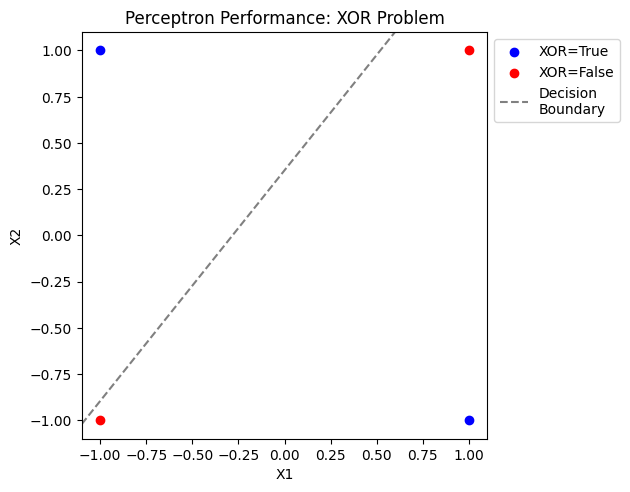

In [97]:
# Calculate decision barrier
# w1 * x1 + w2 * x2 + b = 0
# x2 = (-1/w2) * (w1 * x1 + b)
xs = np.linspace(-1.1, 1.1, 100)
ys = (-1/linear_perceptron.weights[1]) * (linear_perceptron.weights[0] * xs + linear_perceptron.biases)

# View sample space with model
fig, ax = plt.subplots()
ax.scatter(x_xor[(y_xor == 1)[:,0],0], x_xor[(y_xor == 1)[:,0],1], c='b', label='XOR=True')
ax.scatter(x_xor[(y_xor == 0)[:,0],0], x_xor[(y_xor == 0)[:,0],1], c='r', label='XOR=False')
ax.plot(xs, ys, color='gray', linestyle='--', label='Decision\nBoundary')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.title("Perceptron Performance: XOR Problem")

# Part 2: Multi-Layer Models

## The Two-Layer Fully Connected Model

In [ ]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

class TwoLayerNetwork():
    def __init__(self, input_size: int, hidden_size: int = 2):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights
        self.w1 = torch.randn([hidden_size, input_size], dtype=float, requires_grad=False) * (1/sqrt(input_size))
        self.b1 = torch.zeros([hidden_size], dtype=float, requires_grad=False)
        self.w2 = torch.randn([hidden_size], dtype=float, requires_grad=False) * (1/sqrt(hidden_size))
        self.b2 = torch.tensor([0], dtype=float, requires_grad=False)
    
    def forward(self, x: torch.tensor):
        # Forward pass
        z1 = self.w1 @ x + self.b1
        a1 = sigmoid(z1)
        z2 = torch.dot(self.w2, a1) + self.b2
        y_hat = sigmoid(z2)
        if y_hat > 0.5:
            prediction = 1
        else:
            prediction = 0
        return prediction

    def train(self, x_train: torch.tensor, y_train: torch.tensor, epochs: int = 1000, lr: float = 0.1):
        # Evaluation metrics
        training_accuracies = []
        print(f'{"Epoch":<10} \t {"Training Accuracy":^25}')
        print("-" * 60)

        for epoch in range(epochs):
            # Iterate over the training data
            for i, x in enumerate(x_train):
                # Get the label by index
                y = y_train[i]

                # Forward pass
                z1 = self.w1 @ x + self.b1
                a1 = sigmoid(z1)
                z2 = torch.dot(self.w2, a1) + self.b2
                y_hat = sigmoid(z2)
                
                # Backward pass
                delta_y_hat = y_hat - y
                delta_z2 = delta_y_hat * sigmoid_prime(z2)
                delta_b2 = delta_z2
                delta_w2 = delta_z2 * a1
                delta_a1 = delta_z2 * self.w2
                delta_z1 = delta_a1 * sigmoid_prime(z1)
                delta_b1 = delta_z1
                delta_w1 = delta_z1.reshape(self.hidden_size,-1) @ x.reshape(1,-1)

                # Parameter updates
                self.w1 -= lr * delta_w1
                self.b1 -= lr * delta_b1
                self.w2 -= lr * delta_w2
                self.b2 -= lr * delta_b2
            
            # Evaluation metrics for this epoch
            accuracy = self.evaluate(x_train, y_train)
            training_accuracies.append(accuracy)
            if epoch % 200 == 199:
                print(f"{epoch+1:<10} \t {accuracy:^25.3f}")
            
        return training_accuracies

    def evaluate(self, x_eval: torch.tensor, y_eval: torch.tensor):
        # Variable to store accuracy
        N_correct = 0

        # In each epoch, iterate over the entire dataset one example at a time (i.e., no mini-batching)
        for i, x in enumerate(x_eval):
            # Get the label by index
            y = y_eval[i]

            # Forward pass
            z1 = self.w1 @ x + self.b1
            a1 = sigmoid(z1)
            z2 = torch.dot(self.w2, a1) + self.b2
            y_hat = sigmoid(z2)
            
            # Determine accuracy for this example
            if y_hat > 0.5 and y == 1:
                N_correct += 1
            elif y_hat <= 0.5 and y == 0:
                N_correct += 1
        
        accuracy = N_correct / len(x_eval)
        
        return accuracy
    

def evaluate_performance(x_train: torch.tensor, y_train: torch.tensor, N_instances: int = 10, keep_final_accuracies: bool = False) -> tuple[int, dict, list]:
    # Initially, we don't have any perfect models
    N_perfect = 0

    # Initial results
    best_result = {'accuracies': [-np.inf], 'earliest_perfection': np.inf, 'model': None, 'index': np.nan}

    final_accuracies = []

    # Create N instances of the selected model for evaluation
    for i in range(N_instances):
        # Create an instance of the network
        network = TwoLayerNetwork(input_size=x_train.shape[1])

        # Train the network and obtain the accuracies over the epochs
        accuracies = network.train(x_train, y_train)

        # Metrics to test
        final_accuracy = accuracies[-1]
        earliest_perfection = np.inf

        # Increase the number of instances achieving perfect accuracy (if we did)
        if final_accuracy == 1:
            N_perfect += 1
            perfect_epochs = [epoch for epoch, accuracy in enumerate(accuracies) if accuracy == 1]
            earliest_perfection = perfect_epochs[0]

        # Update our best result (if we beat it)
        if (final_accuracy >= best_result['accuracies'][-1]) and (earliest_perfection <= best_result['earliest_perfection']):
            best_result['accuracies'] = accuracies
            best_result['earliest_perfection'] = earliest_perfection
            best_result['model'] = network
            best_result['index'] = i

        # Save the final accuracy for this run (if needed)
        if keep_final_accuracies:
            final_accuracies.append(final_accuracy)
    
    return N_perfect, best_result, final_accuracies


Epoch      	     Training Accuracy    
------------------------------------------------------------


/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_86164/2180416434.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(1.0+np.exp(-z))


200        	           1.000          
400        	           1.000          
600        	           1.000          
800        	           1.000          
1000       	           1.000          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           1.000          
400        	           1.000          
600        	           1.000          
800        	           1.000          
1000       	           1.000          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           1.000          
400        	           1.000          
600        	           1.000          
800        	           1.000          
1000       	           1.000          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           1.000          
400        	           1.000          
600        	           1.000         

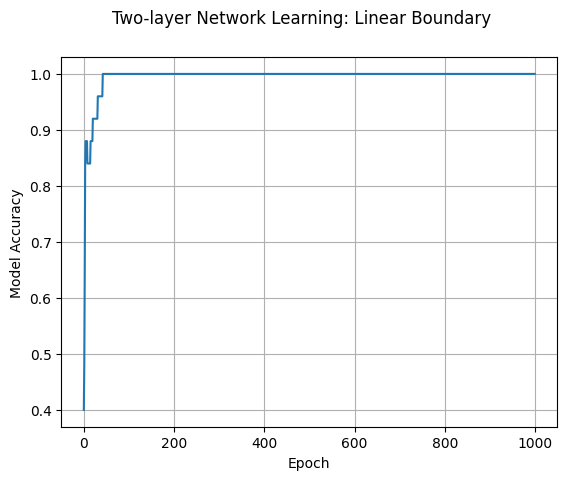

In [119]:
N_perfect_linear, best_result_linear, _ = evaluate_performance(x_train=x_linear, y_train=y_linear)
accuracies = best_result_linear['accuracies']
print(f"The two-layer network achieved perfect accuracy in {N_perfect_linear}/10 instances on the linear dataset.")
print(f"The fastest time-to-perfection in 10 instances was {best_result_linear['earliest_perfection']} epochs.")

plot_model_accuracy(accuracies, title='Two-layer Network Learning: Linear Boundary')

Epoch      	     Training Accuracy    
------------------------------------------------------------


/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_86164/2180416434.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(1.0+np.exp(-z))


200        	           0.500          
400        	           0.500          
600        	           0.500          
800        	           0.500          
1000       	           0.500          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           0.500          
400        	           0.500          
600        	           0.500          
800        	           0.750          
1000       	           0.750          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           0.500          
400        	           0.500          
600        	           0.500          
800        	           0.750          
1000       	           0.750          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           0.500          
400        	           0.500          
600        	           0.500         

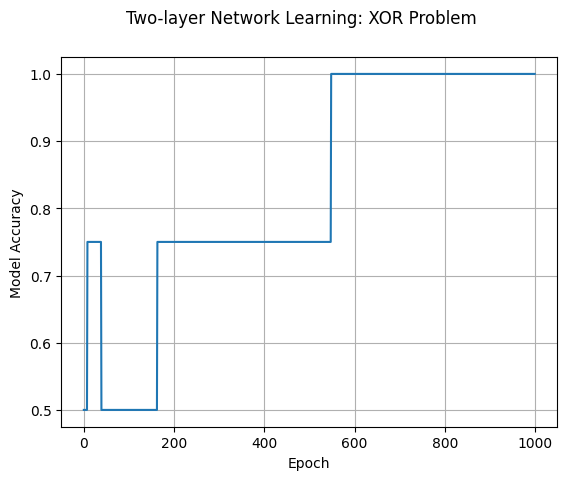

In [123]:
N_perfect_xor, best_result_xor, _ = evaluate_performance(x_train=x_xor, y_train=y_xor)
accuracies = best_result_xor['accuracies']
print(f"The two-layer network achieved perfect accuracy in {N_perfect_xor}/10 instances on the XOR dataset.")
print(f"The fastest time-to-perfection in 10 instances was {best_result_xor['earliest_perfection']} epochs.")

plot_model_accuracy(accuracies, title='Two-layer Network Learning: XOR Problem')

/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_86164/2180416434.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(1.0+np.exp(-z))


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Two-layer Model Decision Boundary: Linear Boundary'}, xlabel='X1', ylabel='X2'>)

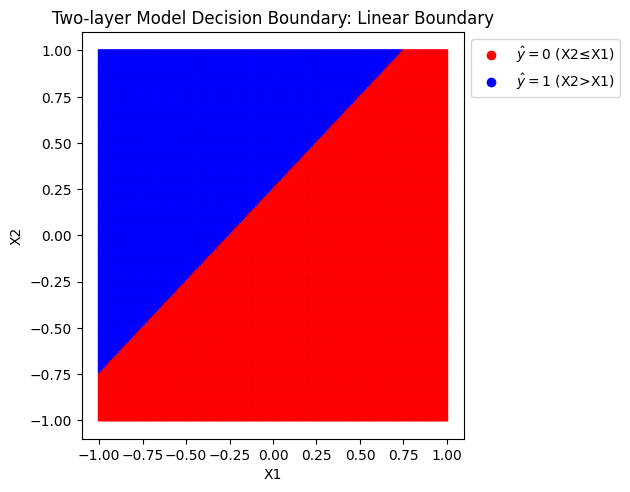

In [124]:
# Create samples
S = np.linspace(-1,1,200)
model = best_result_linear['model']
x,y = make_dataset(S, rule='linear')
y_hat = torch.zeros_like(y)
for i, x_eval in enumerate(x):
    y_hat[i] = model.forward(x_eval)

# View decision boundary
labels = {
    'blue': '$\hat{y}=1$ (X2>X1)',
    'red': '$\hat{y}=0$ (X2≤X1)',
}
plot_dataset(x1=x[:,0], x2=x[:,1], y=y_hat, title='Two-layer Model Decision Boundary: Linear Boundary', labels=labels)

/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_86164/2180416434.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(1.0+np.exp(-z))


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Two-layer Model Decision Boundary: XOR Problem'}, xlabel='X1', ylabel='X2'>)

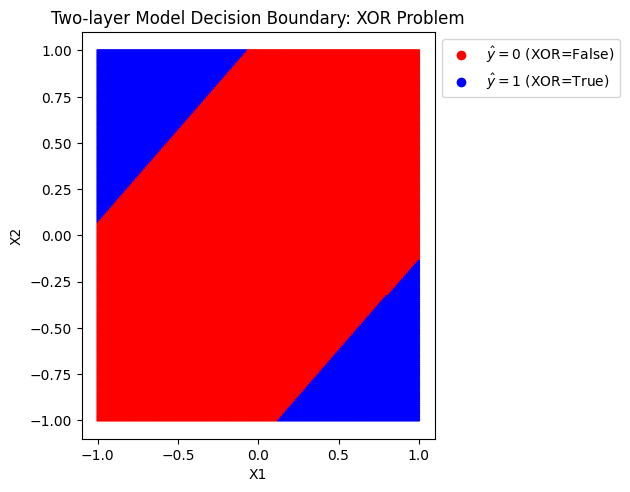

In [125]:
# Create samples
S = np.linspace(-1,1,200)
model = best_result_xor['model']
x,y = make_dataset(S, rule='linear')
y_hat = torch.zeros_like(y)
for i, x_eval in enumerate(x):
    y_hat[i] = model.forward(x_eval)

# View decision boundary
labels = {
    'blue': '$\hat{y}=1$ (XOR=True)',
    'red': '$\hat{y}=0$ (XOR=False)',
}
plot_dataset(x1=x[:,0], x2=x[:,1], y=y_hat, title='Two-layer Model Decision Boundary: XOR Problem', labels=labels)

# Part 3: Harder Datasets

## Noisy XOR

### Dataset Generation

In [132]:
# Define the set
S = [-1, 1]

# Generate 3 versions of an expanded XOR datasets, one for each of r=[0.25, 0.5, 0.75]
# Each expanded dataset should consist of 40 samples using X_noise = X + N, N ~ WN(0,r)
datasets = {}
for r in [0.25, 0.5, 0.75]:
    x_vals = torch.tensor([])
    y_vals = torch.tensor([])
    for _ in range(40):
        # Create the XOR dataset
        x_xor, y_xor = make_dataset(set=S, rule='xor')

        # Create the noise
        noise = torch.randn_like(x_xor) * r

        # Add the noise to the XOR inputs
        x_xor += noise

        # Save the noisy dataset – use concatenation to retain the correct dimensions
        x_vals = torch.cat((x_vals, x_xor), dim=0)
        y_vals = torch.cat((y_vals, y_xor), dim=0)

    datasets[f"r={r}"] = (x_vals, y_vals)

print("Example dataset (r=0.25)")
example=datasets['r=0.25']
print("X has shape: ", example[0].shape)
print("Sample x value: ", example[0][0])
print("y has shape: ", example[1].shape)
print("Sample y value: ", example[1][0])

Example dataset (r=0.25)
X has shape:  torch.Size([160, 2])
Sample x value:  tensor([-1.3571, -0.6380], dtype=torch.float64)
y has shape:  torch.Size([160, 1])
Sample y value:  tensor([0.], dtype=torch.float64)


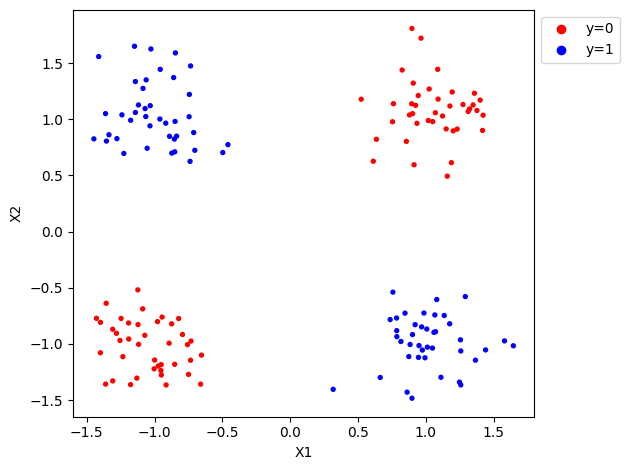

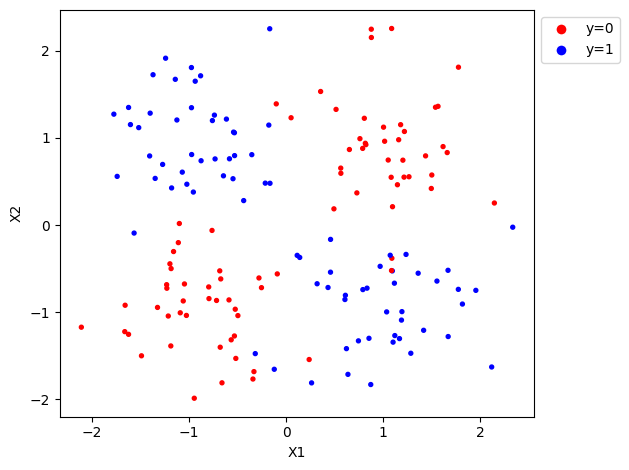

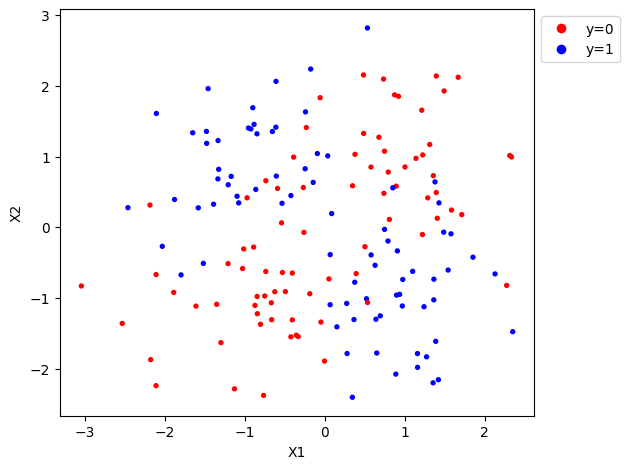

In [136]:
# Create scatter plots of each dataset
for k,v in datasets.items():
    x1 = v[0][:,0]
    x2 = v[0][:,1]
    y = v[1][:,0]
    plot_dataset(x1, x2, y, title=None, marker_size=8)

### Performance Evaluation


In [142]:
# Train 100 different instances of the two-layer model on each noisy XOR dataset
results = {}
for k,v in datasets.items():
    x_train = v[0]
    y_train = v[1]
    _, best_result, final_accuracies = evaluate_performance(x_train, y_train, N_instances=100, keep_final_accuracies=True)
    results[k] = {
        "best_result": best_result,
        "final_accuracies": final_accuracies
    }

Epoch      	     Training Accuracy    
------------------------------------------------------------


/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_5592/2201784306.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(1.0+np.exp(-z))


200        	           1.000          
400        	           1.000          
600        	           1.000          
800        	           1.000          
1000       	           1.000          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           1.000          
400        	           1.000          
600        	           1.000          
800        	           1.000          
1000       	           1.000          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           1.000          
400        	           1.000          
600        	           1.000          
800        	           1.000          
1000       	           1.000          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           0.500          
400        	           0.500          
600        	           0.500         

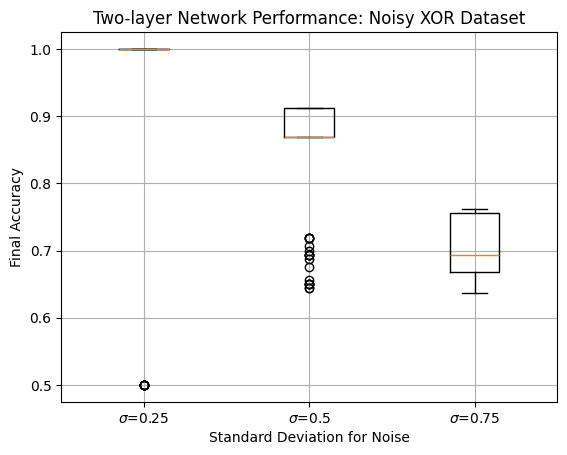

In [143]:
# Create box plot
data_to_plot = [v['final_accuracies'] for v in results.values()]
column_labels = [k.replace("r", "$\sigma$") for k in results.keys()]

fig, ax = plt.subplots()
ax.boxplot(data_to_plot)

ax.set_xticklabels(column_labels)
ax.set_title('Two-layer Network Performance: Noisy XOR Dataset')
ax.set_ylabel('Final Accuracy')
ax.set_xlabel('Standard Deviation for Noise')
ax.grid(True)


/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_5592/2201784306.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(1.0+np.exp(-z))


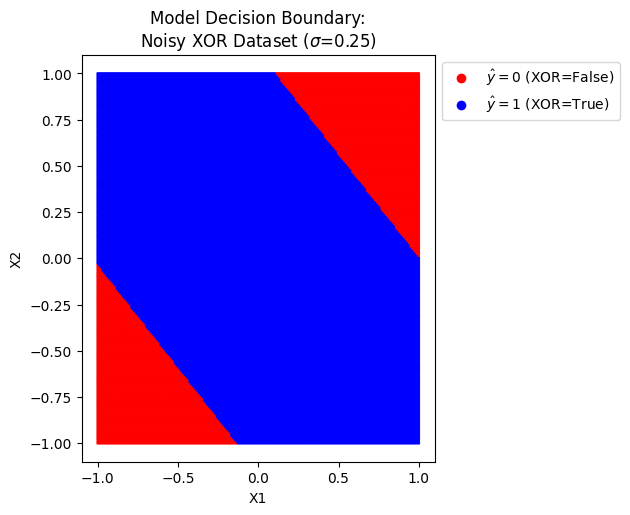

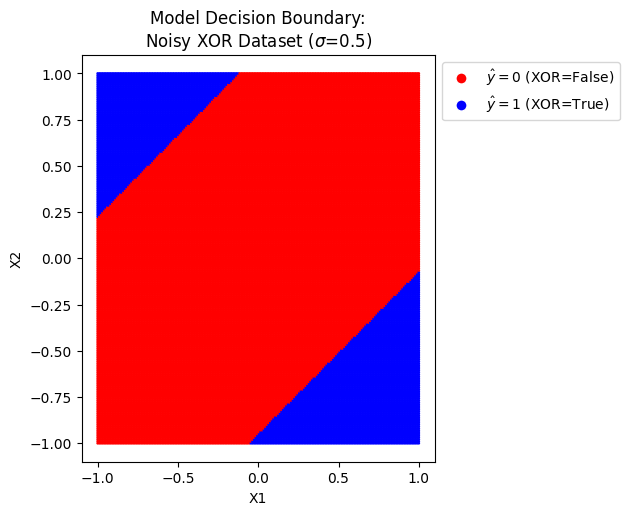

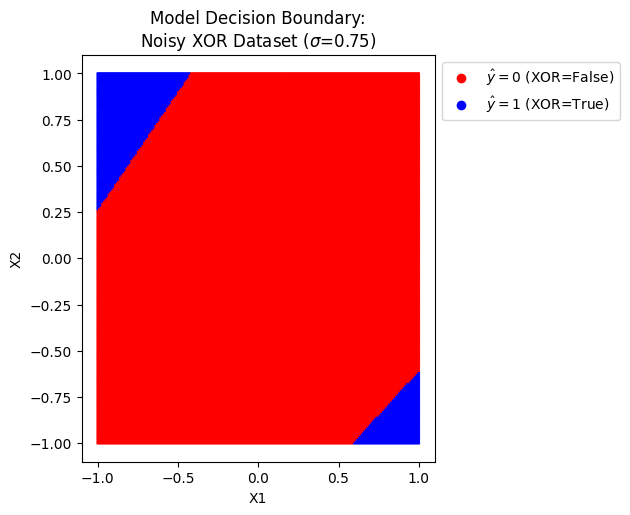

In [144]:
# Create samples
S = np.linspace(-1,1,200)
for k,v in results.items():
    model = v['best_result']['model']
    x,y = make_dataset(S, rule='linear')
    y_hat = torch.zeros_like(y)
    for i, x_eval in enumerate(x):
        try:
            y_hat[i] = model.forward(x_eval)
        except AttributeError as e:
            print(e) 
            break
    labels = {
        'blue': '$\hat{y}=1$ (XOR=True)',
        'red': '$\hat{y}=0$ (XOR=False)',
    }
    k = k.replace("r", "$\sigma$")
    title=f'Model Decision Boundary:\nNoisy XOR Dataset ({k})'
    plot_dataset(x1=x[:,0], x2=x[:,1], y=y_hat, title=title, labels=labels)

## Higher-Dimensional Parity

In [221]:
# Build X data
S = torch.tensor([-1, 1])
x_d4 = torch.cartesian_prod(S,S,S,S).to(float)
x_d6 = torch.cartesian_prod(S,S,S,S,S,S,).to(float)
x_d8 = torch.cartesian_prod(S,S,S,S,S,S,S,S).to(float)

# Helper function
def build_y(x: torch.Tensor) -> torch.Tensor:
    # Initial tensor
    y = torch.zeros(x.shape[0],1, dtype=float)

    # Set elements index-by-index
    for i, x_val in enumerate(x):
        # Determine whether there is an even or odd number of -1 entries
        y[i] = (x_val == -1).sum() % 2

    return y

# Build y data
y_d4 = build_y(x_d4)
y_d6 = build_y(x_d6)
y_d8 = build_y(x_d8)

# Combine datasets
datasets = [(x_d4, y_d4), (x_d6, y_d6), (x_d8, y_d8)]
labels=('d_input=4', 'd_input=6', 'd_input=8')

results = {}

# Iterate through and train
for i, (x_train, y_train) in enumerate(datasets):
    label = labels[i]

    model1 = TwoLayerNetwork(input_size=x_train.shape[1], hidden_size=x_train.shape[1])
    model2 = TwoLayerNetwork(input_size=x_train.shape[1], hidden_size=2)

    accuracies1 = model1.train(x_train, y_train)
    accuracies2 = model2.train(x_train, y_train)

    hidden_label = label.replace("d_input", "d_hidden")
    results[label] = {
        hidden_label: accuracies1,
        'd_hidden=2': accuracies2
    }


Epoch      	     Training Accuracy    
------------------------------------------------------------


/var/folders/7m/3r23lm6s517bl9502bgqp64w0000gn/T/ipykernel_86164/2180416434.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1.0/(1.0+np.exp(-z))


200        	           0.500          
400        	           0.500          
600        	           0.500          
800        	           0.500          
1000       	           0.500          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           0.438          
400        	           0.500          
600        	           0.500          
800        	           0.500          
1000       	           0.500          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           0.484          
400        	           0.469          
600        	           0.469          
800        	           0.500          
1000       	           0.547          
Epoch      	     Training Accuracy    
------------------------------------------------------------
200        	           0.453          
400        	           0.531          
600        	           0.500         

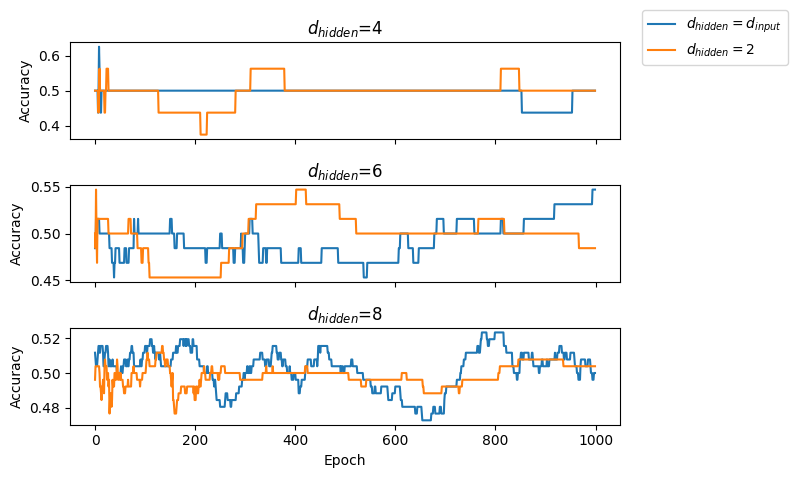

In [222]:
# Model accuracy vs. epoch for each dataset
fig, axs = plt.subplots(3,1, sharex=True)
for i, (k,v) in enumerate(results.items()):
    hidden_label = k.replace("d_input", "d_hidden")
    model1_accuracies = v[hidden_label]
    model2_accuracies = v['d_hidden=2']
    ax = axs[i]
    epochs = range(len(model1_accuracies))
    ax.plot(epochs, model1_accuracies, label='$d_{hidden}=d_{input}$')
    ax.plot(epochs, model2_accuracies, label='$d_{hidden}=2$')
    ax.set_ylabel("Accuracy")
    k = k.replace("d_input", "$d_{hidden}$")
    ax.set_title(k)
    if i == 2:
        ax.set_xlabel("Epoch")
        handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()


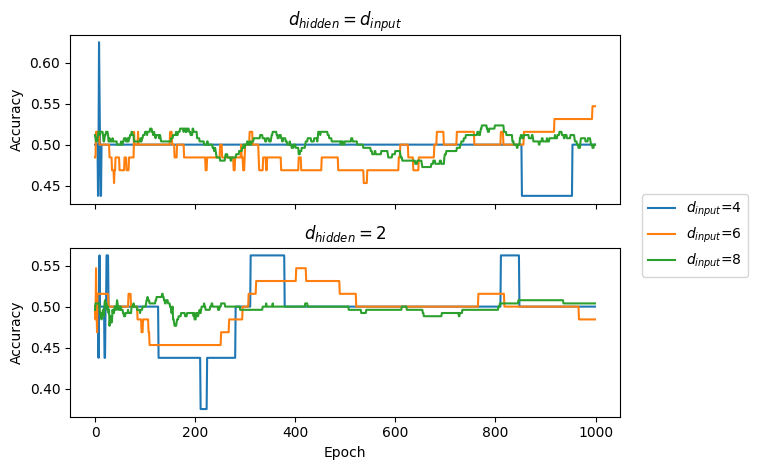

In [223]:
# Model accuracy vs. epoch for each model version
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
for k,v in results.items():
    hidden_label = k.replace("d_input", "d_hidden")
    model1_accuracies = v[hidden_label]
    model2_accuracies = v['d_hidden=2']
    epochs = range(len(model1_accuracies))
    ax1.plot(epochs, model1_accuracies, label=k.replace("d_input", "$d_{input}$"))
    ax2.plot(epochs, model2_accuracies, label=k)
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
ax1.set_title("$d_{hidden}=d_{input}$")
ax2.set_title("$d_{hidden}=2$")
ax2.set_xlabel("Epoch")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1,0.6))
plt.tight_layout()